In [8]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import pandas as pd
import sklearn 

In [9]:
import matplotlib.mlab as mlab
import random

####  $N(0,1)$  n obsevations

In [10]:
def simData( n, seed_num ):
    np.random.seed(seed_num)
    x = np.random.normal( 0.0, 1.0, n )
    return x 


### kernel

 - rectangular kernel: $K(u) =1_{\{-1/2<u\leq 1/2\}}$    
 - parabolic kernel: $K(u) = \frac{3}{4}(1-u^2)_+$
 - gaussian kernel: $K(u) = \frac{1}{\sqrt{2\pi}}\exp(-\frac{u^2}{2})$
 - sine kernel: $K(u) = \frac{sin(u)}{\pi u}$

In [74]:
def rectangularKernel(u):
    return 0.5 * (1 - (np.absolute(u) >1 ) ) 

def parabolicKernel(u):
    return np.maximum( 3.0 /  4 * ( 1 - np.power(u,2)), 0)

def gaussianKernel(u):
    return 1.0 / sqrt(2*pi) * exp(- np.power(u,2) / 2) 

def sineKernel(u):
    return np.sin(u) / (pi * u)


In [75]:
kernelDict = {"rectangular": rectangularKernel, "parabolic": parabolicKernel, "gaussian": gaussianKernel, "sine": sineKernel}

#### Estimate $f(y)$ using kernel method

In [76]:
def kernelDensity(nameKernel ,X , y,bandwidth):
    n = len(X)
    f_y = 0
    for i in range(n):
        f_y += 1.0/ ( n*bandwidth ) * kernelDict[nameKernel]( (y - X[i])/ bandwidth )
    return f_y


#### Compare the performance of different kernels  

In [77]:
def plotDensity( X, bandwidth):

    z = np.linspace(-3, 3, 600)

    fig, axs = plt.subplots(2,2, figsize=(15, 13))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    for i in range(4):
        nameKernel = list(kernelDict)[i]
        f_Arr = []
        for j in range(600):
            f_Arr.append(kernelDensity( nameKernel, X, z[j], bandwidth))
        axs[i].scatter( z, f_Arr , marker = '.', color = 'blue')
        axs[i].plot(z,mlab.normpdf(z, 0, 1))
        axs[i].set_title(nameKernel)
    plt.show()
    

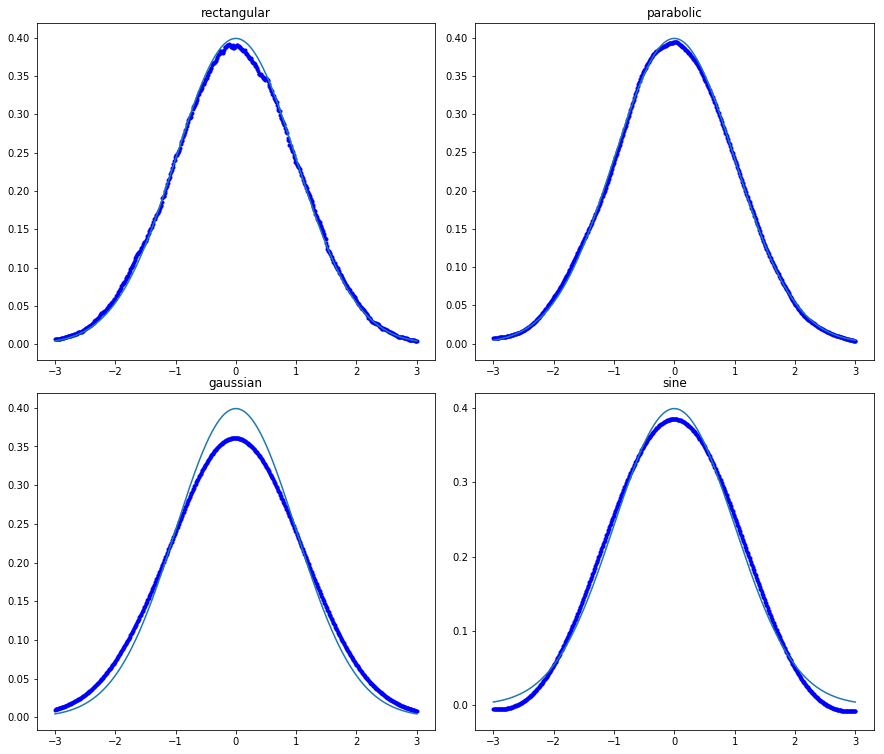

In [115]:
X = simData(4000, 7)
plotDensity( X, 0.5)


#### Calculate Gini's Purity

$ gp(s) = \sum_i(X_i-\bar{X})^2 -\sum_{\{i: X_i\leq s\}}(X_i-\bar{X_l})-\sum_{\{i: X_i> s\}}(X_i-\bar{X_r})$

In [18]:
def ginisPurity(X ,s):
    s = int(s)
    X1 = []; X2 = []
    n = len(X)
    X1 = X[0:s]; X2 = X[s:]
    if len(X1) == 0 or len(X2) == 0 :
        gp =  len(X) * np.var(X)
    else: 
        gp = len(X1) * np.var(X1) +   len(X2) * np.var(X2)
    return len(X) * np.var(X) - gp
    

##### Obtain the best split
$s_{best} =\arg \max gp(s)$

In [46]:
def bestSplit(X):
    X = sorted(X)
    maximum = -1
    split = 0
    for i in range(1,len(X)):
        gp = ginisPurity(X,i)
        if gp > maximum :
            maximum = gp
            split = i
    return split, maximum

In [47]:
a = [2,4,5]
split, maximum = bestSplit(a)
print("split: " ,split, "    maximum:" ,maximum)

split:  1     maximum: 4.16666666667


#####  Obtain the sequence of best splits

$s_1,s_2,\cdots s_n $

In [48]:
def splitSequence(X,numSplit):
    X = sorted(X)
    splitList = []; splitList.append(0); splitList.append(len(X) )
    for k in range(numSplit):
        if k == 0:
            currSplit, currMax = bestSplit(X)
            splitList.append(currSplit)
            splitList = sorted(splitList)
        else: 
            maximum = -1
            split = 0  
            for i in range(1,len(splitList)):
                currSplit, currMax = bestSplit( X[splitList[i-1]: splitList[i]] )
                currSplit = splitList[i-1] + currSplit
                if currMax > maximum:
                    maximum = currMax
                    split = currSplit
            if split not in splitList:
                splitList.append(split)
                splitList  = sorted(splitList)
                
    return splitList     
        

In [78]:
X = simData(4000, 7)
splitList = splitSequence(X,10)
print(splitList)

[0, 32, 181, 616, 1256, 1965, 2694, 3302, 3594, 3802, 3957, 4000]


##### Density estimation 

For any point $x$, if it locates in two secuctive split points, estimte $f(x)$ as the proportion of data in locates in the secuctive split points

In [119]:

def CARTdensity(X, numSplit):
    
    
    X = sorted(X)
    n = len(X)
    splitList = splitSequence(X,numSplit)
    splitPointInd = splitList[1:]
    valueList = [];
    for i in range(1,len(splitList)):
        valueList.append( (splitList[i]-splitList[i-1]) / n)

        
    z = np.linspace(-3, 3, 600)
    fz = []
    m = len(z)
    for i in range(m):
        if z[i] <= X[splitPointInd[0]-1]:
            fz.append(valueList[0] /  (X[splitPointInd[0]-1] - X[0]))
        elif z[i] > X[splitPointInd[-2]-1]:
            fz.append(valueList[-1] / (X[splitPointInd[-1]-1] - X[splitPointInd[-2]-1]))
        else:
            for j in range(len(splitPointInd) - 2):
                if z[i] > X[splitPointInd[j]-1] and z[i] <= X[splitPointInd[j+1]-1]:
                    fz.append(valueList[j+1] / (X[splitPointInd[j+1]-1]-X[splitPointInd[j]-1]))
    plt.figure()    
    plt.plot(z,mlab.normpdf(z, 0, 1),color = "red")  
    plt.scatter(z,fz,marker = '.',color = "blue",s = 1)
    
    plt.figure()
    plt.hist(X, numSplit, normed = 1, facecolor='gray', alpha = 0.75, range = [-3,3])
    z = np.linspace(-3, 3, 600)
    plt.plot(z,mlab.normpdf(z, 0, 1),color = "red")
    
    plt.show()

    return splitPointInd 


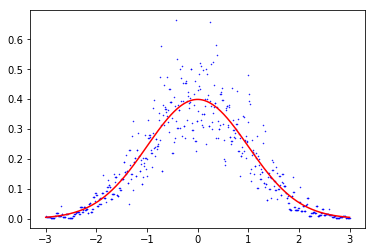

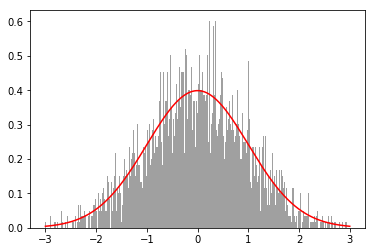

In [120]:
X = simData(4000,7)



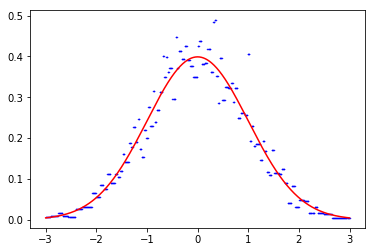

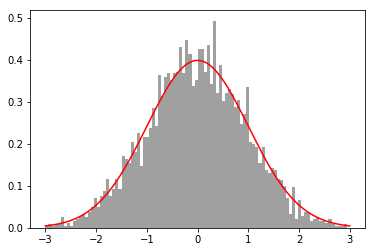

In [121]:
splitPointInd = CARTdensity(X,100)

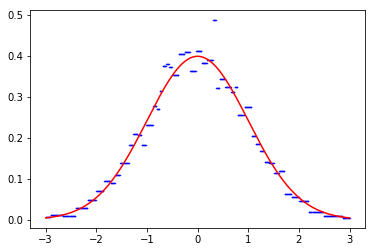

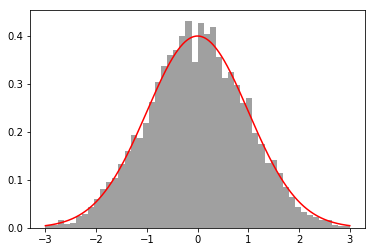

In [122]:
splitPointInd = CARTdensity(X,50)

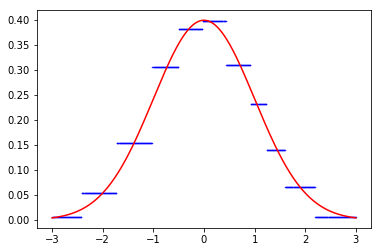

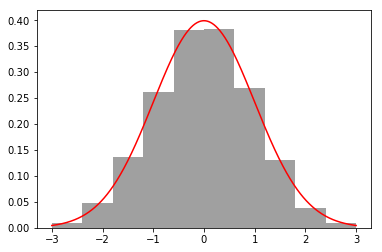

In [123]:
splitPointInd = CARTdensity(X,10)

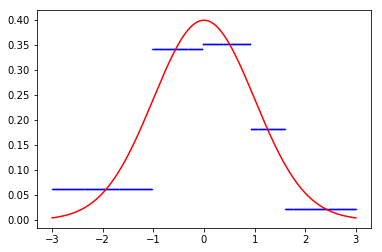

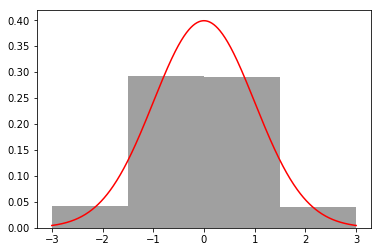

In [124]:
splitPointInd = CARTdensity(X,4)

In [19]:
from scipy import linalg as LA
import numpy as np
import pandas as pd

In [44]:

def pMatrix(n,i):
    n = int(n); i = int(i)
    P1 = 1.0 * (n-i) / ( n * i ) * np.matrix(np.ones((i,i)))
    P2 = -1.0 / n * np.matrix(np.ones((i,n-i))) 
    P3 = P2.transpose()
    P4 = 1.0 * i / (n * (n-i) ) * np.matrix(np.ones((n-i,n-i)))
    P = np.concatenate((np.concatenate((P1,P2), axis = 1), np.concatenate((P3,P4),axis = 1)), axis = 0)
    
    return P
    

In [93]:
P = pMatrix(8,5)

# 
print(pd.DataFrame(P))
e_vals, e_vecs = LA.eig(P)
print("eigenValue:  ",e_vals)
print("eigenVector:   ",pd.DataFrame(e_vecs))
# print(pd.DataFrame(e_vecs.transpose()* P * e_vecs-np.diag(e_vals)))
# print("eigenValue:  ",e_vals)
print(np.dot(e_vecs.transpose(),e_vecs))

       0      1      2      3      4         5         6         7
0  0.075  0.075  0.075  0.075  0.075 -0.125000 -0.125000 -0.125000
1  0.075  0.075  0.075  0.075  0.075 -0.125000 -0.125000 -0.125000
2  0.075  0.075  0.075  0.075  0.075 -0.125000 -0.125000 -0.125000
3  0.075  0.075  0.075  0.075  0.075 -0.125000 -0.125000 -0.125000
4  0.075  0.075  0.075  0.075  0.075 -0.125000 -0.125000 -0.125000
5 -0.125 -0.125 -0.125 -0.125 -0.125  0.208333  0.208333  0.208333
6 -0.125 -0.125 -0.125 -0.125 -0.125  0.208333  0.208333  0.208333
7 -0.125 -0.125 -0.125 -0.125 -0.125  0.208333  0.208333  0.208333
eigenValue:   [  0.00000000e+00+0.j   1.00000000e+00+0.j  -1.37253584e-17+0.j
  -6.16297582e-33+0.j  -4.70406589e-49+0.j  -5.33343552e-34+0.j
   9.88982175e-67+0.j   0.00000000e+00+0.j]
eigenVector:              0         1         2         3         4         5         6  \
0 -0.961769 -0.273861  0.353553  0.559916 -0.961769 -0.935382 -0.961769   
1  0.077981 -0.273861  0.353553 -0.015125  0.